# Example: Consensus with Differential Privacy Mechanism

This notebook demonstrates a Laplacian-matrix-based consensus implementation with a
**differential privacy (DP) communication mechanism**.

In this example, each node applies a DP mechanism to its local state before sending it
to its neighbors, in order to limit the information leakage during inter-node
communication.

The DP mechanism is implemented as a pluggable transform that conforms to the project's
transform protocol, so users can easily replace it with their own privacy mechanisms.

This experiment runs multiple processes as computing nodes on a single machine.
For deploying nodes across multiple machines (e.g., Raspberry Pi over TCP), refer to
[examples/scripts/node.py](../scripts/node.py) for a runnable template and integration
details.

## 1. Global parameters

In [1]:
if __name__ == "__main__":
    N_STATE = 3

    import logging

    logging.basicConfig(level=logging.INFO)

    from conops import Graph, bootstrap

    NODES = ["1", "2", "3", "4", "5"]
    EDGES = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]
    N_NODES = len(NODES)

    graph = Graph(NODES, EDGES, transport="ipc")

## 2. Deploy the nodes using multiprocessing:
Here, we use the consensus iteration formula:
$$
x(k+1) = x(k) - \alpha L x(k),
$$
where $L$ is the Laplacian matrix of the graph.

In [2]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray


def laplacian_consensus(idx: str, n_state: int, n_iter: int = 50) -> NDArray[float64]:
    from numpy import zeros
    from numpy.random import uniform, seed
    from conops import NodeHandle
    from conops.transform import DPMechanism

    transform = DPMechanism(epsilon=1.0, sensitivity=1.0)

    nh = NodeHandle(idx, transform=transform, transport="ipc")

    x = zeros((n_iter, n_state))
    seed(int(idx))  # Ensure reproducibility for each node
    x[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        x[k + 1] = x[k] - nh.laplacian(x[k]) * 0.45

    return x


if __name__ == "__main__":
    with Pool(N_NODES + 1) as pool:
        bootstrap(graph)

        tasks = [
            pool.apply_async(laplacian_consensus, args=(str(i + 1), N_STATE))
            for i in range(N_NODES)
        ]

        node_states = [task.get() for task in tasks]

INFO:conops.bootstrap:Node '1' joined graph 'default' from @conops-default-1.
INFO:conops.bootstrap:Node '2' joined graph 'default' from @conops-default-2.
INFO:conops.bootstrap:Node '3' joined graph 'default' from @conops-default-3.
INFO:conops.bootstrap:Node '5' joined graph 'default' from @conops-default-5.
INFO:conops.bootstrap:Node '4' joined graph 'default' from @conops-default-4.
INFO:conops.bootstrap:Graph 'default' registration complete.
INFO:conops.bootstrap:Sent neighbor info to all nodes in graph 'default'.
INFO:conops.node_handle:Node '1' joined graph 'default'.
INFO:conops.node_handle:Node '2' joined graph 'default'.
INFO:conops.node_handle:Node '4' joined graph 'default'.
INFO:conops.node_handle:Node '3' joined graph 'default'.
INFO:conops.node_handle:Node '5' joined graph 'default'.
INFO:conops.node_handle:Node '4' received neighbor info and set up sockets.
INFO:conops.node_handle:Node '2' received neighbor info and set up sockets.
INFO:conops.node_handle:Node '1' recei

**Note:**
The order in which the nodes and server are started does not affect the overall program.

## 3. Plot the results:

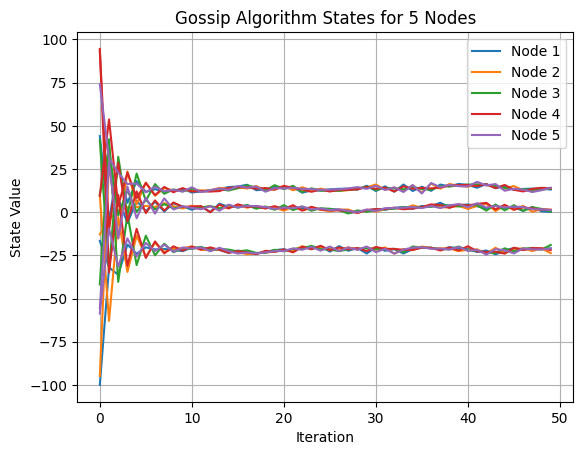

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    _, ax = plt.subplots()

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for i in range(N_NODES):
        states = node_states[i]
        for j in range(N_STATE):
            (line,) = ax.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax.set_xlabel("Iteration")
    ax.set_ylabel("State Value")
    ax.grid()
    ax.legend()
    ax.set_title(f"Gossip Algorithm States for {N_NODES} Nodes")